# Semantic Segmentation
https://pytorch.org/docs/stable/torchvision/models.html

The models subpackage contains definitions for the following model architectures for semantic segmentation:
- FCN ResNet101
- DeepLabV3 ResNet101

As with image classification models, all pre-trained models expect input images normalized in the same way. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. They have been trained on images resized such that their minimum size is 520.

The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset. You can see more information on how the subset has been selected in references/segmentation/coco_utils.py. The classes that the pre-trained model outputs are the following, in order:
~~~
['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
~~~

~~~
CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4, 1, 64, 20, 63, 7, 72]
~~~

In [23]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
from pycocotools.coco import COCO
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import torch.optim as optim
import torch
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101
import torch.nn.functional as F
import os
from tqdm import tqdm
from torchsummary import summary
import datetime
%matplotlib inline

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
os.listdir('/home/euloo/Documents/datasets/coco2017')

['test2017', 'image_info_test', 'val2017', 'annotations', 'train2017']

In [5]:
dataDir = '/home/euloo/Documents/datasets/coco2017'

trainDataType ="train2017"
trainAnnFile = "{}/annotations/instances_{}.json".format(dataDir,trainDataType)

valDataType = "val2017"
valAnnFile = "{}/annotations/instances_{}.json".format(dataDir,valDataType)

In [6]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None, transform=None, target_transform=None):
        super().__init__(root, annFile, transforms, transform, target_transform)
        
#         self.coco_cats = ['__background__', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#                      'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorcycle',
#                      'person', 'potted plant', 'sheep', 'couch', 'train', 'tv']
#         cats = self.coco.loadCats(self.coco.getCatIds(catNms=self.coco_cats))
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.id_to_class, self.layer_to_name, self.layer_to_cat = {}, {}, {}
        self.id_to_class[0] = 0
        self.layer_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.layer_to_name[it+1] = cat['name']
            self.layer_to_cat[cat['id']] = cat['name']
    def to_one_hot(self, tensor, nClasses):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,nClasses,h,w).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot
    
    def __getitem__(self, index):
        img, ann = super().__getitem__(index)
        width, height = img.size[:2]
        msk = np.zeros((height, width))
        
        padding=(
                    320-int(width /2) if width  % 2 == 0 else 320-int(width /2)-1,
                    320-int(height /2) if height  % 2 == 0 else 320-int(height /2)-1,
                    320-int(width /2),
                    320-int(height/2)
                )
        
        img_T = transforms.Compose(([
            transforms.Pad(padding),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
        
        msk_T = transforms.Compose(([
            transforms.ToPILImage(),
            transforms.Pad(padding),
            transforms.ToTensor()
        ]))
        
        categories = set()
        for it in ann:
            if it['category_id'] in self.id_to_class:
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                compressed_rle = compressed_rle if isinstance(compressed_rle, list) else [compressed_rle]
                bw = np.sum(mask.decode(compressed_rle), axis = 2).astype(bool)
                msk[bw] = self.id_to_class[it['category_id']]
                categories.add(self.layer_to_cat[it['category_id']])
        msk = msk_T(msk.astype(np.float32)).long()
        return img_T(img), msk, self.to_one_hot(msk, len(self.id_to_class)), list(categories)
        #return img_T(img), msk_T(msk.astype(np.float32).reshape((height, width))).long(), list(categories)

In [7]:
trainDataType = '/home/euloo/Documents/datasets/coco2017/train2017'
valDataType = '/home/euloo/Documents/datasets/coco2017/val2017'

In [8]:
print(trainAnnFile)
print(valAnnFile)

/home/euloo/Documents/datasets/coco2017/annotations/instances_train2017.json
/home/euloo/Documents/datasets/coco2017/annotations/instances_val2017.json


In [9]:
train_set = Dataset(trainDataType, trainAnnFile)
val_set = Dataset(valDataType, valAnnFile)

loading annotations into memory...
Done (t=16.73s)
creating index...
index created!
loading annotations into memory...
Done (t=2.11s)
creating index...
index created!


In [10]:
train_set.__len__(), val_set.__len__()

(118287, 5000)

In [11]:
#train_set.layer_to_name
#train_set.id_to_class
#train_set.layer_to_cat

In [10]:
img, msk, label, cats = val_set[3]
print(img.shape,msk.shape, label.shape, cats)

torch.Size([3, 640, 640]) torch.Size([1, 640, 640]) torch.Size([1, 81, 640, 640]) ['truck', 'stop sign', 'car']


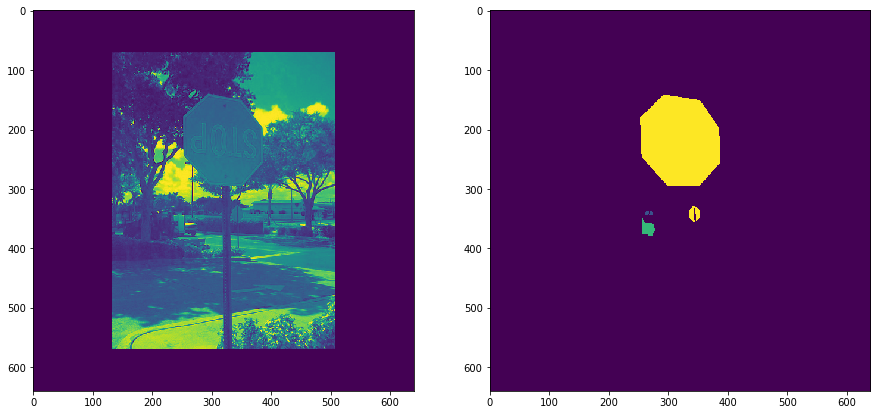

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(img)[0,:,:])
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(msk)[0,:,:]);

~~~
(classifier): FCNHead(
    (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
  )
~~~

In [14]:
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101
import torch.nn.functional as F

class Net(nn.Module): 
    def __init__(self, net='fcn_resnet50', pretrained = False):
        super(Net, self).__init__()
        self.net = net
            
        if self.net == 'fcn_resnet50':
            self.net = fcn_resnet50(pretrained = pretrained)
            self.net.classifier._modules['4'] = nn.Conv2d(512, 81, kernel_size=(1, 1), stride=(1, 1))

        elif self.net == 'fcn_resnet101':
            self.model = fcn_resnet101(pretrained = pretrained) 

    def forward(self, x):
        if (self.net == 'fcn_resnet50') or (self.net == 'fcn_resnet101'):
            x = self.model.backbone(x)
            x = self.model.classifier(x)
            #x = self.model.aux_classifier(x)
             
        return x

In [12]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
#         self.net = deeplabv3_resnet50()
        self.net = fcn_resnet50()
        self.net.classifier[4] = nn.Conv2d(512, 81, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.net(x)
        return x['out']

In [15]:
#model = torchvision.models.segmentation.fcn_resnet101(pretrained=False)
#model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
#model = torchvision.models.segmentation.fcn_resnet50(pretrained=False)
#model = Net(net='fcn_resnet50', pretrained=False).to(device)
model = Net()

In [16]:
#model = model.to(device)

In [18]:
#model
model = model.to(device)

In [19]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)

In [19]:
def rescale(img):
    return (1/(2.64*2.1179)) * img + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


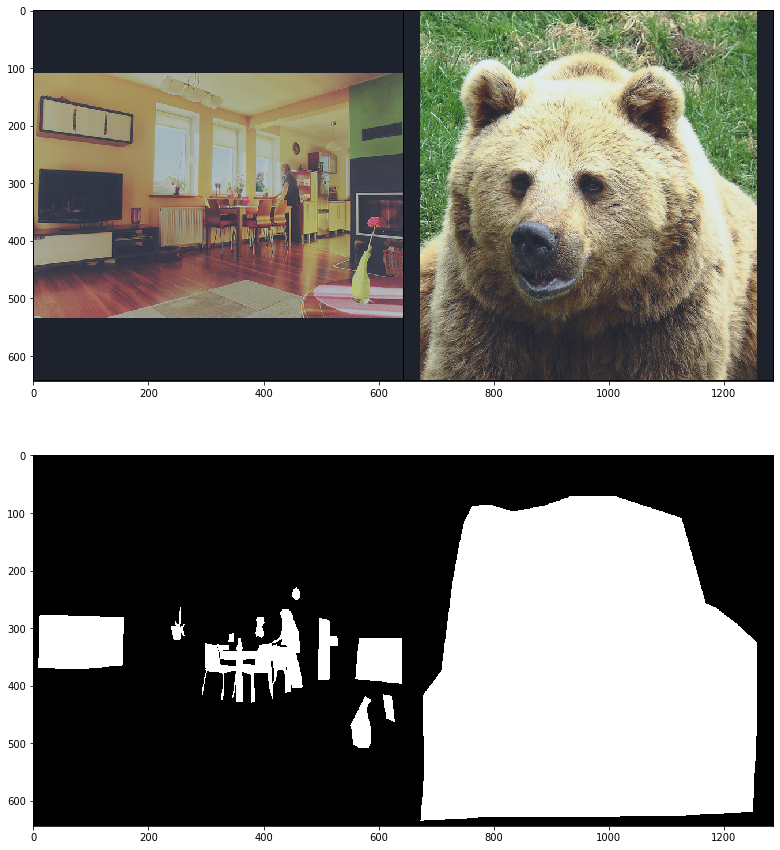

In [20]:
images, labels, cats = next(iter(val_loader))
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.imshow(torchvision.utils.make_grid(rescale(images)).numpy().transpose(1,2,0))
plt.subplot(212)
plt.imshow(torchvision.utils.make_grid(labels.squeeze(0).float()).numpy().transpose(1,2,0))

In [21]:
torch.cuda.empty_cache()

%%time
model.eval()

with torch.no_grad():
    outputs = model(images.to(device))

loss_function = nn.BCEWithLogitsLoss()

#pos_weights=torch.FloatTensor([81,81])
#loss_function = nn.BCEWithLogitsLoss(pos_weights)
#loss_function = nn.CrossEntropyLoss()
#
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)
def iou(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded#.mean()  # Or thresholded.mean() if you are interested in average across the batch

epochs = 1

%%time
print("epoch|loss |val_loss|acc  |v_acc|")
for epoch in range(epochs): # entire dataset is passed forward and backward through the nn
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)

    
            running_loss = 0
            IoU = 0
            total = 0
    
    
    
            for batch_idx, training_batch in enumerate(train_loader):        
                inputs, labels  = training_batch[0].to(device), training_batch[1].to(device)


                # zero the parameter gradients
                optimizer.zero_grad()
                print("zero grad")

                # forward propagation
                outputs = model(inputs)
                outputs = Variable(outputs[:,:1,:,:], requires_grad=True).cuda()
                print(outputs)
                loss = loss_function(outputs, labels)#['out']
                print(loss)

                #backward propagation
                loss.backward()

                # Update the parameters(weight,bias)
                optimizer.step()
                """

                running_loss += loss.item()# .data
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                
                IoU = iou(predicted, labels)
                """
"""
        elif phase == 'valid':
            with torch.no_grad():
                model.train(False)
                validation_loss = 0
                v_correct = 0
                v_total = 0


                for batch_idx, valid_batch in enumerate(valid_loader):
                    val_inputs, val_labels = valid_batch[0].to(device), valid_batch[1].to(device)
                    val_outputs = model(val_inputs)

                    # validation loss
                    val_loss = loss_function(val_outputs, val_labels)
                    validation_loss += val_loss.item()

                    # validation accuracy
                    _, predicted = torch.max(val_outputs.data, 1)
                    v_total += val_labels.size(0)
                    v_IoU = iou(predicted, val_labels)
                                    

        
    print('%5d|%.3f| %.3f  |%.3f|%.3f|' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           IoU / total, v_IoU / v_total
           ))          

            

                    
    loss_list.append(running_loss / len(train_loader))
    val_loss_list.append(validation_loss / len(valid_loader))

    accuracy_list.append(IoU / total)
    v_accuracy_list.append(v_IoU / v_total)
"""

# Slicing
t = torch.Tensor([[[[0, 0], [0, 0]], [[1, 1], [1, 1]], [[2, 2], [2, 2]]], [[[0, 0], [0, 0]], [[1, 1], [1, 1]], [[2, 2], [2, 2]]]])
print(t.dim())
print(t)
print(t[0])
# Every row, only the last column
print(t[:, -1])

# First 2 rows, all columns
print(t[:2, :])

# Lower right most corner
print(t[-1:, -1:])

%%time
model.eval()

with torch.no_grad():
    for i, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)

In [26]:
!nvidia-smi

Sat Nov  9 15:23:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:22:00.0  On |                  N/A |
| 41%   72C    P2    51W / 180W |   2550MiB /  8112MiB |     80%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

out = outputs['out']
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
om

plt.imshow(om)
plt.show()

# Define the helper function
def decode_segmap(image, nc=21):
   
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
     
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [ ]:
plt.imshow(np.transpose(images[0].cpu(), (1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(images[0].cpu())[0,:,:])
plt.subplot(122)
plt.imshow(rgb)

# marsel

In [20]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return -loss.mean()

In [21]:
# pos_weights=torch.FloatTensor([81,81])
# criterion = nn.BCEWithLogitsLoss(pos_weights)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# criterion = CrossEntropyLoss2d()
# criterion = mIoULoss()

# optimizer = optim.Adam([
#     {'params': [param for name, param in model.named_parameters() if name[-4:] == 'bias'],
#      'lr': 2*1e-5},
#     {'params': [param for name, param in model.named_parameters() if name[-4:] != 'bias'],
#      'lr': 1e-5, 'weight_decay': 1e-4}
# ], betas=(0.95, 0.999))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [24]:
for epoch in range(3):   
    start=datetime.datetime.now()
    for i, data in enumerate(train_loader):
        if i != 0 and i % 10000 == 0:
            break
        torch.cuda.empty_cache()
        inputs, masks, labels, cats = data
        
        inputs=inputs.cuda()
#         labels=labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        
#         loss = criterion(torch.argmax(outputs, dim=1).unsqueeze(1).cpu().float(), masks.float()) #BCEWithLogitsLoss
        loss = criterion(outputs.cpu(), masks[:,0,:,:].cpu().long()) #CrossEntropyLoss 
#         loss = criterion(outputs, labels) #IoU
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('[%s] [epoch %d]\t[iter %d / %d]\t[train loss %.5f]' % (
                datetime.datetime.now()-start, epoch, i + 1, len(train_loader), loss.item()
            ))
            start=datetime.datetime.now()
    
#     net.eval()

#     for vi, data in enumerate(val_loader):
#         if i != 0 and i % 10000 == 0:
#             break
#         torch.cuda.empty_cache()
#         inputs, masks, labels, cats = data
        
#         inputs=inputs.cuda()
#         labels=labels.cuda()

#         outputs = model(inputs)
       
#         v_loss = criterion(outputs, labels)
#         v_loss = v_loss.item()
        

#     print('--------------------------------------------------------------------')
#     print('[epoch %d]\t[val loss %.5f]' % (
#         epoch, v_loss))

#     print('--------------------------------------------------------------------')

#     net.train()

[0:03:50.283680] [epoch 0]	[iter 100 / 59144]	[train loss 1.03980]
[0:02:59.910775] [epoch 0]	[iter 200 / 59144]	[train loss 1.24395]
[0:02:47.692161] [epoch 0]	[iter 300 / 59144]	[train loss 0.43714]
[0:02:46.838915] [epoch 0]	[iter 400 / 59144]	[train loss 0.91044]
[0:02:48.264667] [epoch 0]	[iter 500 / 59144]	[train loss 0.42257]
[0:02:48.239810] [epoch 0]	[iter 600 / 59144]	[train loss 0.15816]
[0:02:48.038566] [epoch 0]	[iter 700 / 59144]	[train loss 1.27575]
[0:02:47.968075] [epoch 0]	[iter 800 / 59144]	[train loss 2.04219]
[0:02:48.042508] [epoch 0]	[iter 900 / 59144]	[train loss 0.22542]
[0:02:47.492158] [epoch 0]	[iter 1000 / 59144]	[train loss 1.52622]
[0:02:48.543194] [epoch 0]	[iter 1100 / 59144]	[train loss 1.15006]
[0:02:48.685339] [epoch 0]	[iter 1200 / 59144]	[train loss 0.82986]
[0:02:47.920312] [epoch 0]	[iter 1300 / 59144]	[train loss 0.52556]
[0:02:48.256616] [epoch 0]	[iter 1400 / 59144]	[train loss 0.97889]
[0:02:49.094677] [epoch 0]	[iter 1500 / 59144]	[train los

KeyboardInterrupt: 

In [25]:
torch.save(model, '1epoch_7100from10000from59144.pt')

/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type IntermediateLayerGetter. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness

In [26]:
modelnet=torch.load('1epoch_7100from10000from59144.pt')
model.eval()

Net(
  (net): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

In [28]:
def rescale(img):
    return (1/(2.64*2.1179)) * img + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('person', 'person'), ('bus', 'backpack'), ('car', 'skateboard')]


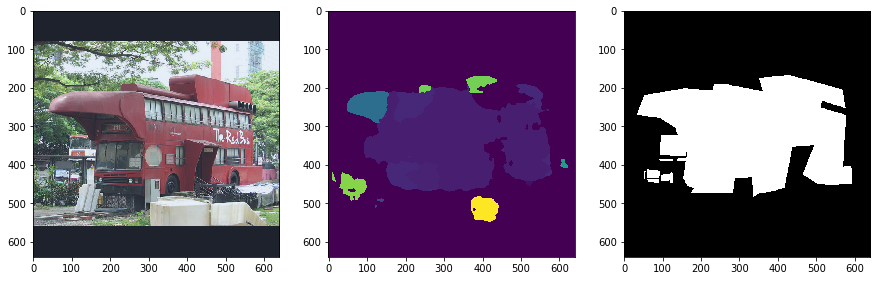

In [30]:
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(inputs[0].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[0].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[0].squeeze(0).float()).numpy().transpose(1,2,0));

In [ ]:
print(cats)
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torchvision.utils.make_grid(rescale(inputs[0].detach().cpu())).numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(torch.argmax(outputs, dim=1)[0].detach().cpu())
plt.subplot(133)
plt.imshow(torchvision.utils.make_grid(masks[0].squeeze(0).float()).numpy().transpose(1,2,0));